<a href="https://colab.research.google.com/github/x110/DLToolboxImg/blob/master/TrainedModelPerformance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
colab = True

In [0]:
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    drive.mount("/content/drive", force_remount=True)

In [0]:
if colab:    
    # Remove CUDA 9 completely
    !apt-get --purge remove cuda nvidia* libnvidia-*
    !apt-get remove cuda-*
    !dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
    !apt autoremove
    !apt-get update

In [0]:
if colab:
    # Install CUDA 8
    !wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64/cuda-repo-ubuntu1604_8.0.61-1_amd64.deb
    !dpkg -i --force-overwrite cuda-repo-ubuntu1604_8.0.61-1_amd64.deb
    !apt-get update
    !apt-get install cuda-8-0

    # install will fail, need to force dpkg to overwrite the configuration file

    !wget http://archive.ubuntu.com/ubuntu/pool/main/m/mesa/libglx-mesa0_18.0.5-0ubuntu0~18.04.1_amd64.deb
    !dpkg -i --force-overwrite libglx-mesa0_18.0.5-0ubuntu0~18.04.1_amd64.deb

    !wget http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64/nvidia-410_410.48-0ubuntu1_amd64.deb
    !dpkg -i --force-overwrite nvidia-410_410.48-0ubuntu1_amd64.deb

    !apt --fix-broken install
    !apt-get install cuda-8-0

    #More packages ro install 
    !pip uninstall -y numpy
    !pip uninstall -y scipy
    !pip install turicreate
    # The worng version of MXNET will be installed.
    !pip uninstall -y mxnet
    !pip install scipy
    # Instal CUDA8-compatible version of mxnet 1.1.0
    !pip install mxnet-cu80==1.1.0

In [0]:
if colab:
    root_path = "/content/drive/My Drive/x110/"
else:
    root_path = "/home/mas/"
    
PATH = "x110/"

In [10]:
if colab:
    !mkdir {PATH}
    !mkdir {PATH+"Datasets"}
    !mkdir {PATH+"Datasets/Dataset5/"}
    !mkdir {PATH+"Datasets/Dataset5/processed/"}
    !mkdir {PATH+"model"}

    !mkdir x110/DLToolboxImg
    !git clone https://github.com/x110/DLToolboxImg.git x110/DLToolboxImg


    dataset_path = root_path+'Datasets/Dataset5/processed/.'
    !cp -a "{dataset_path}" {PATH+"Datasets/Dataset5/processed/"}


mkdir: cannot create directory ‘x110/’: File exists
mkdir: cannot create directory ‘x110/DLToolboxImg’: File exists
fatal: destination path 'x110/DLToolboxImg' already exists and is not an empty directory.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib nbagg

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [0]:
import sys
sys.path.insert(0,"x110/DLToolboxImg/src/")
import mynnet7 as nn
import mxnet as mx
import random

In [0]:
model_path1 = root_path+"model/model16/"
#model details
prefix1 = "feb02"
model_epoch=108

model_path2 = root_path+"model/model16/"
prefix2 = "feb02"


In [0]:
bs = 1#34#100

In [0]:
#Dataset Path 
interm_dir4 = root_path+ "Datasets/Dataset5/processed/"
s = "2018_11_25"
train_data_path=interm_dir4+'train'+s+'pos.rec'
train_idx_path=interm_dir4+'train'+s+'pos.idx'
valid_data_path=interm_dir4+'valid'+s+'pos.rec'
valid_idx_path=interm_dir4+'valid'+s+'pos.idx'
test_data_path=interm_dir4+'test'+s+'pos.rec'
test_idx_path=interm_dir4+'test'+s+'pos.idx'

In [0]:
drivefile = model_path1+prefix1+"-"+"{:04d}".format(model_epoch)+".params"
drivefile2 = model_path1+prefix1+"-symbol.json"
colabfile = PATH+"model/"+prefix1+"-"+"{:04d}".format(model_epoch)+".params"
colabfile2 = PATH+"model/"+prefix1+"-symbol.json"

!cp  "{drivefile}" {colabfile}
!cp  "{drivefile2}" {colabfile2}


In [0]:
import mynnet7 as nn
import pickle
import mxnet as mx
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



In [0]:
import mxnet as mx
import sys, os
import random
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import cv2
import pandas as pd
import re
from mxnet.io import DataIter
from mxnet.io import DataBatch
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
from collections import namedtuple
import pickle

Batch = namedtuple('Batch', ['data'])

BATCH_SIZE,INPUT_SIZE_z,INPUT_SIZE_y, INPUT_SIZE_x = 8,32,32,32

class FileIter(DataIter):
    def __init__(self, path,path_idx,
                 data_name="data",
                 label_name="softmax_label",
                 batch_size=1,
                 do_augment=False,
                 random_flip=False,
                 random_rot=False,
                 random_elastic=False, 
                 mean_image=.28,
                 std_image = .28,
                 do_shuffle = True):

        
        random.seed(313)
        self.ind2=None
        self.do_shuffle = do_shuffle
        self.epoch = 0
        self.mean_image = mean_image
        self.std_image = std_image
        
        super(FileIter, self).__init__()
        self.batch_size = batch_size
        self.do_augment=do_augment
        self.random_flip = random_flip
        self.random_rot = random_rot
        self.random_elastic = random_elastic

        self.data_name = data_name
        self.label_name = label_name

        self.record = mx.recordio.MXIndexedRecordIO(path_idx, path, 'r')#mx.recordio.MXRecordIO(path, 'r')

        
        def readrecord(record):
            record.reset()
            num_data=0
            while True:
                item = record.read()
                num_data+=1
                if not item:
                    break
            return num_data-1
        
        
        self.num_data = readrecord(self.record)#len(open(self.flist_name, 'r').readlines())
        
        
        
        self.idx = self.shuffle_idx()
        self.cursor = -1
        self.cursor2 = -1
        self.ind = self.idx[0]
        self.record.reset()

        self.data, self.label = self._read()
        self.reset()
            
    def shuffle_idx(self):
        num_data = self.num_data//self.batch_size*self.batch_size
        idx = [i for i in range(num_data)]
        if self.do_shuffle:
            random.shuffle(idx)
        idx = np.array(idx)
        idx = idx.reshape(-1,self.batch_size)
        return idx
    
    def _read(self):
        """get two list, each list contains two elements: name and nd.array value"""
                
        data = {}
        label = {}

        dd = []
        ll = []
        
        if self.ind2 is None:
            ind = self.ind
        else:
            ind = self.ind2
            self.ind2=None
            
        for i in range(0, self.batch_size):
            
            item = self.record.read_idx(ind[i])            
            header, l = mx.recordio.unpack_img(item)
            
            d=header.label

            d=d.reshape((32,32,32))- self.mean_image
            d = d/self.std_image
            
            l=l.reshape((32,32,32))
            
            if self.random_elastic:            
              if random.randint(0, 100) > 50:
                d=np.array([elastic_transform(subd, 34, 4) for subd  in d])
                l=np.array([elastic_transform(subl, 34, 4) for subl  in l])

                
            data11=np.concatenate((d,l),axis=0)  
            

            if self.random_rot:
              if random.randint(0, 100) > 50:
                n,rows,cols = data11.shape
                rot =40* random.random()-20
                M = cv2.getRotationMatrix2D((cols/2,rows/2),rot,1)
                data11=np.array([cv2.warpAffine(d,M,(cols,rows))for d in data11])

            d,l=np.vsplit(data11,2)

            if self.random_flip:
            	l=l.reshape((32,32,32))
            	d,l = random_flip_img(d,l, horizontal_chance=0.5, vertical_chance=0.5)

            d = np.expand_dims(d, axis=0) 
            d = np.expand_dims(d, axis=0)
            l=l.reshape((32*32*32))
            l=l.astype(float)
            l = np.expand_dims(l, axis=0)



            dd.append(d)
            ll.append(l)

        d = np.vstack(dd)
        l = np.vstack(ll)
        data[self.data_name] = d
        label[self.label_name] = l
        res = list(data.items()), list(label.items())
        return res

    @property
    def provide_data(self):
        """The name and shape of data provided by this iterator"""
        res = [(k, tuple(list(v.shape[0:]))) for k, v in self.data]
        # print "data : " + str(res)
        return res

    @property
    def provide_label(self):
        """The name and shape of label provided by this iterator"""
        res = [(k, tuple(list(v.shape[0:]))) for k, v in self.label]
        return res
    

    def reset(self):
        self.cursor = -1
        self.cursor2 = -1
        self.record.reset()
        self.epoch += 1
        self.idx = self.shuffle_idx()
        


    def getpad(self):
        return 0

    def iter_next(self):
        self.cursor += self.batch_size
        self.cursor2 += 1
        num_data = self.num_data//self.batch_size*self.batch_size
            

        if self.cursor < self.num_data:
            self.ind = self.idx[self.cursor2]
            return True
        else:
            return False

    def eof(self):
        res = self.cursor >= self.num_data
        return res

    def next(self):
        """return one dict which contains "data" and "label" """
        if self.iter_next():
            self.data, self.label = self._read()
 
            res = DataBatch(data=[mx.nd.array(self.data[0][1])], label=[mx.nd.array(self.label[0][1])], pad=self.getpad(), index=None)

            return res
        else:
            raise StopIteration




In [0]:
from scipy.ndimage.interpolation import zoom
        

In [0]:
def resample(self):

    image=self.image_HU.copy() #zxy

    image=image.swapaxes(0,2) #yxz
    image=image.swapaxes(0,1) #xyz

    resize_factor = self.original_spacing/self.desired_spacing

    new_real_shape = image.shape * resize_factor

    new_shape = np.round(new_real_shape)

    real_resize_factor = new_shape/image.shape

    new_spacing = self.original_spacing/real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')

    image=image.swapaxes(0,2) #zyx
    image=image.swapaxes(1,2) #zxy

    return image, new_spacing

In [0]:
import os
import math

In [0]:
x_mean=0.28
x_std = 0.28

In [19]:
BATCH_SIZE=bs
train_iter=FileIter(train_data_path,
                    train_idx_path,
                    batch_size=BATCH_SIZE,
                    random_elastic = False,
                    random_flip=False,
                    random_rot=False,
                    do_augment=False,
                    mean_image=x_mean,
                    std_image = x_std,
                    do_shuffle=False)

input_shapes = dict(train_iter.provide_data+train_iter.provide_label)
print(input_shapes)

{'data': (1, 1, 32, 32, 32), 'softmax_label': (1, 32768)}


In [0]:
BATCH_SIZE=bs
valid_iter=FileIter(valid_data_path,
                    valid_idx_path,
                    batch_size=BATCH_SIZE,
                    do_augment=False,
                    mean_image=x_mean,
                    std_image = x_std,
                    do_shuffle=False)

In [0]:
train_iter.reset()
valid_iter.reset()

In [0]:
def dice_coef2(label, y):
    smooth = 1.
    label=mx.nd.array(label).as_in_context(mx.gpu(0))
    y=mx.nd.array(y).as_in_context(mx.gpu(0))
    intersection = mx.nd.sum(label*y)
    return ((2. * intersection + smooth) / (mx.nd.sum(label) +mx.nd.sum(mx.nd.abs(y)) + smooth))


In [23]:
!ls

cuda-repo-ubuntu1604_8.0.61-1_amd64.deb  {PATH}		  sample_data
drive					 {PATH+Datasets}  x110
nvidia-410_410.48-0ubuntu1_amd64.deb	 {PATH+model}


In [0]:
def logloss2(label, y,w=[.9,.1]):
    smooth = 1.
    label=mx.nd.array(label).as_in_context(mx.gpu(0))
    y=mx.nd.array(y).as_in_context(mx.gpu(0))
    eps=1e-12
    return mx.nd.mean(-(w[0]*label*mx.nd.log(y+eps)+w[1]*(1-label)*mx.nd.log(1-y+eps)))

In [0]:
# ===============Evaluation metric(s)================= 
eval_metrics_1 =  mx.metric.CustomMetric(feval=logloss2)
eval_metrics_2 = mx.metric.CustomMetric(feval=nn.dice_coef2)
metric= mx.metric.CompositeEvalMetric()
for child_metric in [eval_metrics_1, eval_metrics_2]:
  metric.add(child_metric)

In [0]:
network, arg_params, aux_params = mx.model.load_checkpoint(model_path1+prefix1 , model_epoch)

# Binding
exe = network.simple_bind(ctx=mx.gpu(0), **input_shapes)


exe.copy_params_from(arg_params, aux_params)

# get handle to input arrays
arg_arrays = dict(zip(network.list_arguments(), exe.arg_arrays))
data = arg_arrays[train_iter.provide_data[0][0]]
label = arg_arrays[train_iter.provide_label[0][0]]


In [0]:
network, arg_params, aux_params = mx.model.load_checkpoint(model_path2+prefix2 ,108)
exe.copy_params_from(arg_params, aux_params)

In [0]:
if colab:
  #logfile = "errorlogmodel10.csv"
  logfile = model_path2+"errorlogmodel16.csv"

else:
  logfile = model_path2+"errorlogmodel16.csv"


In [0]:
def get_sample_at(valid_iter,n):
    valid_iter.ind2=[n]
    return valid_iter.next()

In [0]:


arg_arrays = dict(zip(network.list_arguments(), exe.arg_arrays))
data = arg_arrays[train_iter.provide_data[0][0]]
label = arg_arrays[train_iter.provide_label[0][0]]



In [0]:
batch = valid_iter.next()

In [39]:
p.shape

(32, 32, 32)

In [42]:
p.min(),p.max()

(1.705598e-09, 1.0)

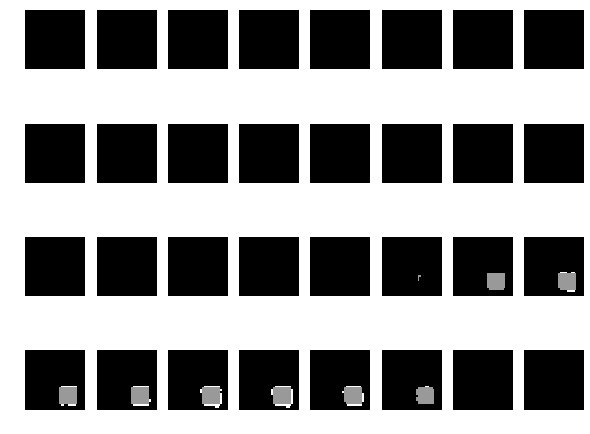

In [48]:
msk2 = p>0.5
zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(msk2[i], 'gray',vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none',  alpha=0.4, vmin=0, vmax=1)




In [0]:
data[:] = batch.data[0]       
label[:] = batch.label[0]
# predict
outputs = exe.forward(is_train=False)


p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))


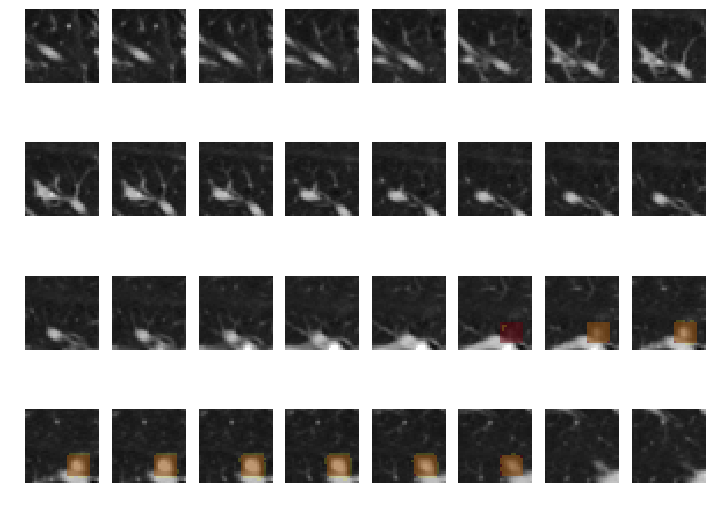

In [71]:

                              
img = X*x_std+x_mean
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], 'gray',vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.5, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.plasma, alpha=0.2, vmin=0, vmax=1)


      
plt.tight_layout()

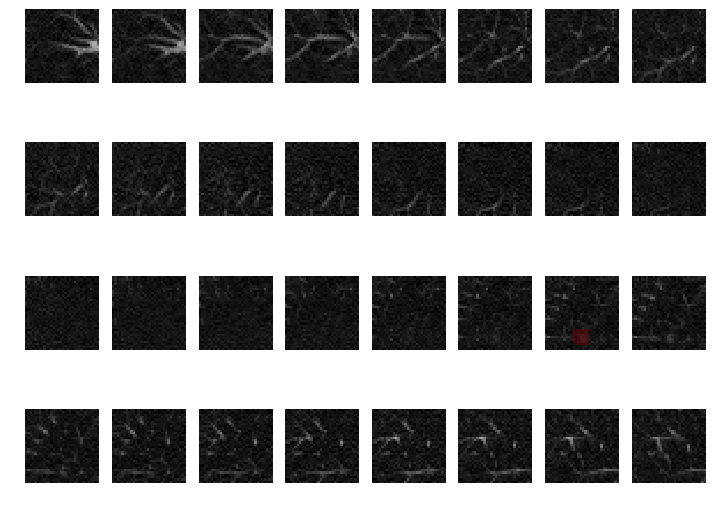

In [72]:
batch = train_iter.next()


data[:] = batch.data[0]       
label[:] = batch.label[0]
# predict
outputs = exe.forward(is_train=False)


p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X*x_std+x_mean
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], 'gray',vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.5, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.plasma, alpha=0.2, vmin=0, vmax=1)

      
plt.tight_layout()

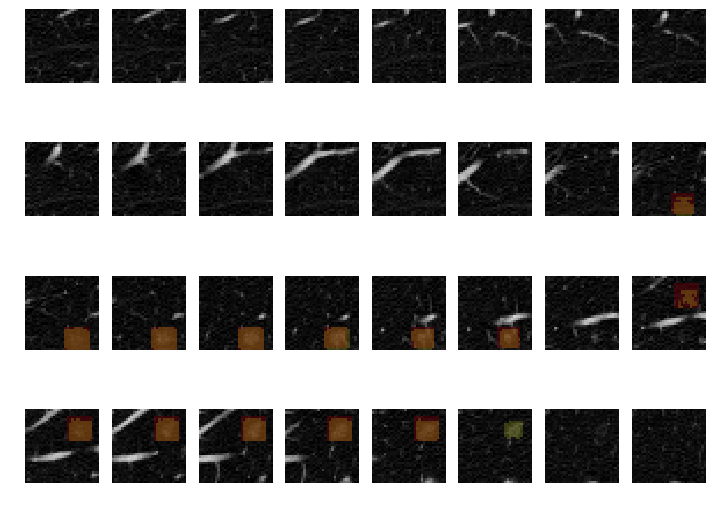

In [73]:
batch = train_iter.next()


data[:] = batch.data[0]       
label[:] = batch.label[0]
# predict
outputs = exe.forward(is_train=False)


p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X*x_std+x_mean
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], 'gray',vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.5, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.plasma, alpha=0.2, vmin=0, vmax=1)

      
plt.tight_layout()

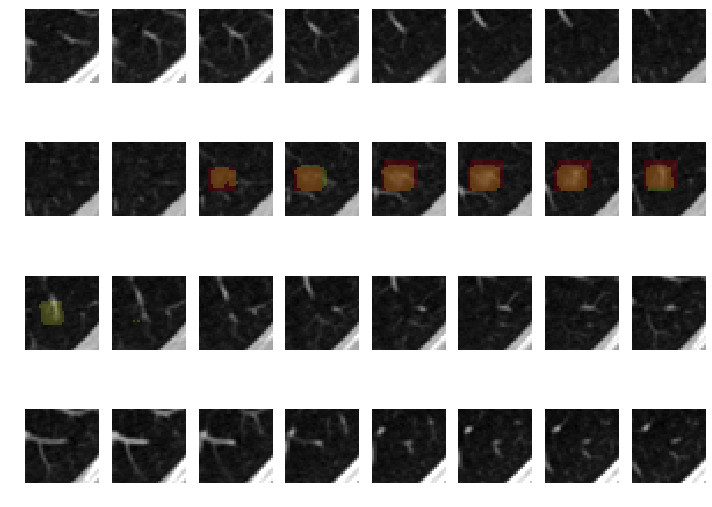

In [74]:
batch = train_iter.next()


data[:] = batch.data[0]       
label[:] = batch.label[0]
# predict
outputs = exe.forward(is_train=False)


p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X*x_std+x_mean
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], 'gray',vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.5, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.plasma, alpha=0.2, vmin=0, vmax=1)

      
plt.tight_layout()

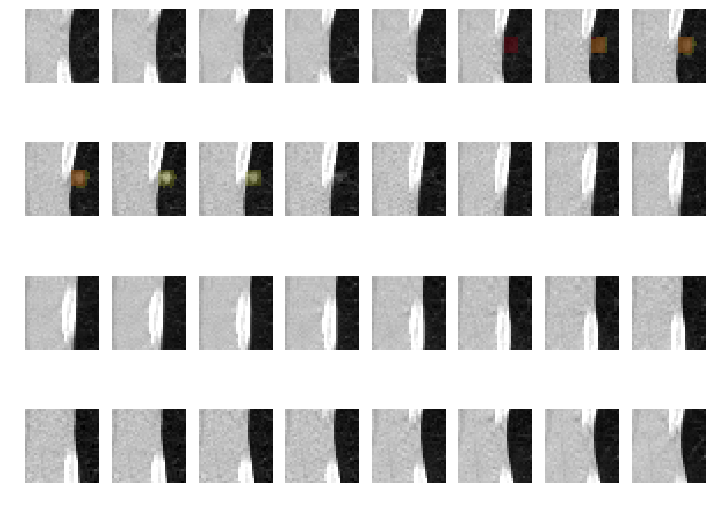

In [75]:
batch = train_iter.next()


data[:] = batch.data[0]       
label[:] = batch.label[0]
# predict
outputs = exe.forward(is_train=False)


p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X*x_std+x_mean
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], 'gray',vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.5, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.plasma, alpha=0.2, vmin=0, vmax=1)

      
plt.tight_layout()

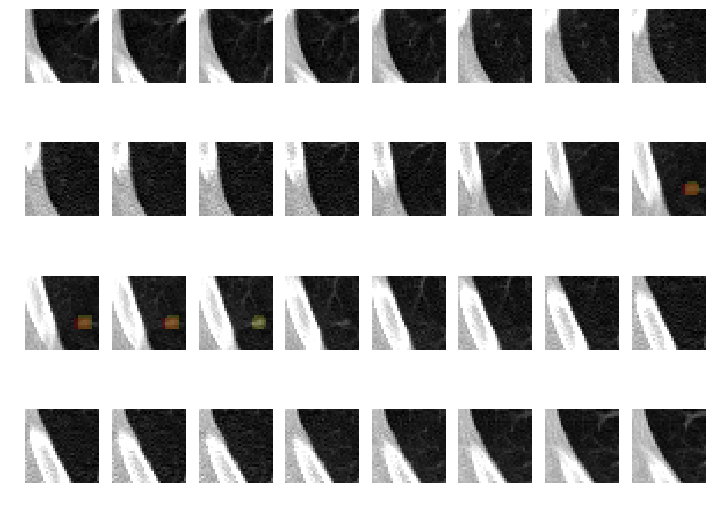

In [76]:
batch = train_iter.next()


data[:] = batch.data[0]       
label[:] = batch.label[0]
# predict
outputs = exe.forward(is_train=False)


p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X*x_std+x_mean
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], 'gray',vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.5, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.plasma, alpha=0.2, vmin=0, vmax=1)

      
plt.tight_layout()

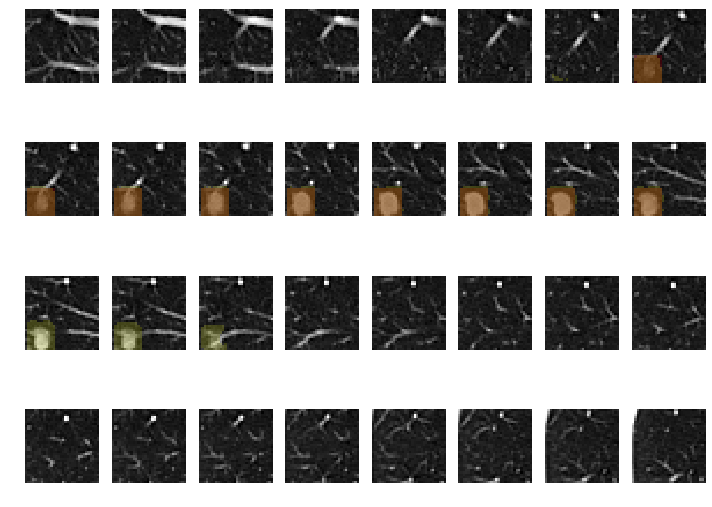

In [77]:
batch = train_iter.next()


data[:] = batch.data[0]       
label[:] = batch.label[0]
# predict
outputs = exe.forward(is_train=False)


p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X*x_std+x_mean
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], 'gray',vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.5, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.plasma, alpha=0.2, vmin=0, vmax=1)

      
plt.tight_layout()

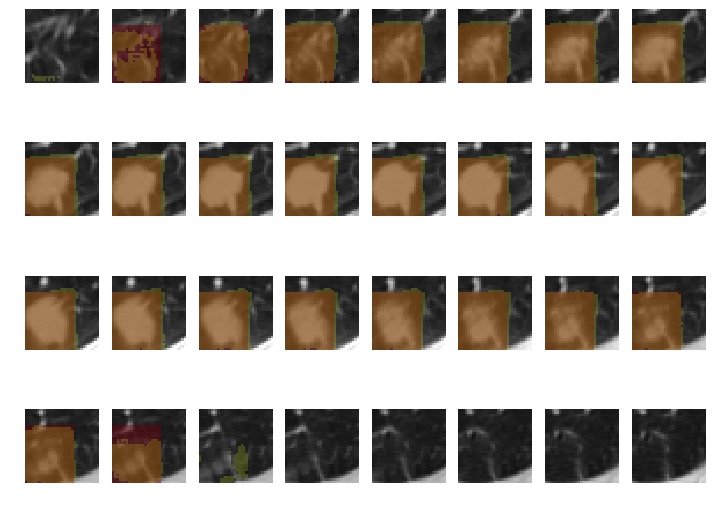

In [78]:
batch = train_iter.next()


data[:] = batch.data[0]       
label[:] = batch.label[0]
# predict
outputs = exe.forward(is_train=False)


p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X*x_std+x_mean
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], 'gray',vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.5, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.plasma, alpha=0.2, vmin=0, vmax=1)

      
plt.tight_layout()

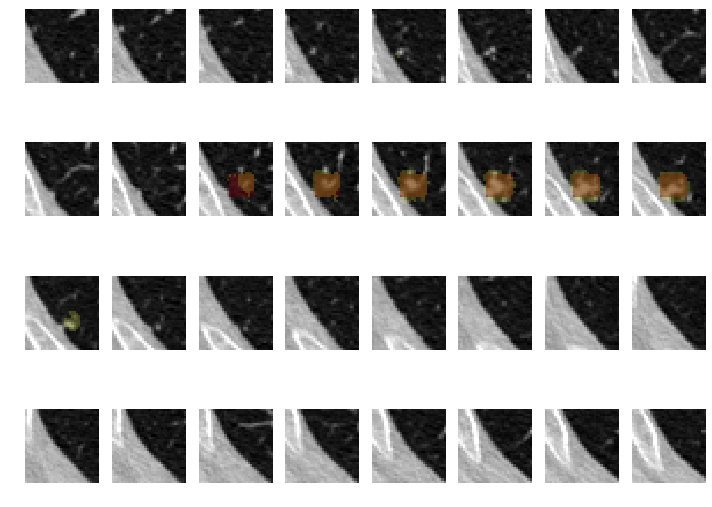

In [79]:
batch = train_iter.next()


data[:] = batch.data[0]       
label[:] = batch.label[0]
# predict
outputs = exe.forward(is_train=False)


p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X*x_std+x_mean
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], 'gray',vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.5, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.plasma, alpha=0.2, vmin=0, vmax=1)

      
plt.tight_layout()

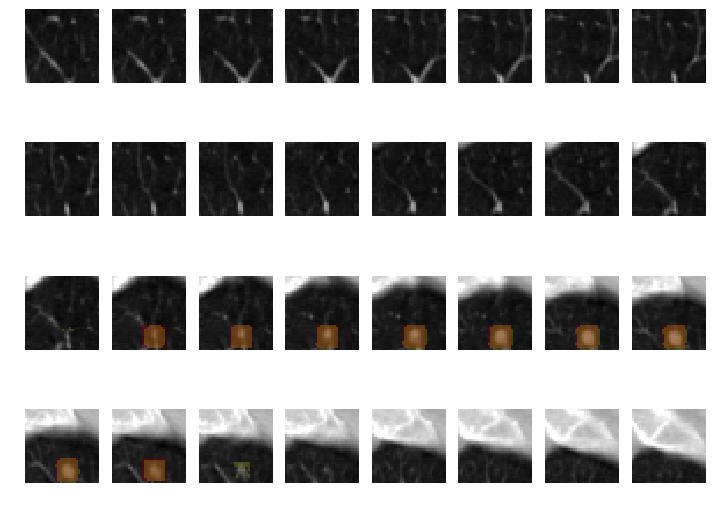

In [80]:
batch = train_iter.next()


data[:] = batch.data[0]       
label[:] = batch.label[0]
# predict
outputs = exe.forward(is_train=False)


p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X*x_std+x_mean
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], 'gray',vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.5, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.plasma, alpha=0.2, vmin=0, vmax=1)

      
plt.tight_layout()

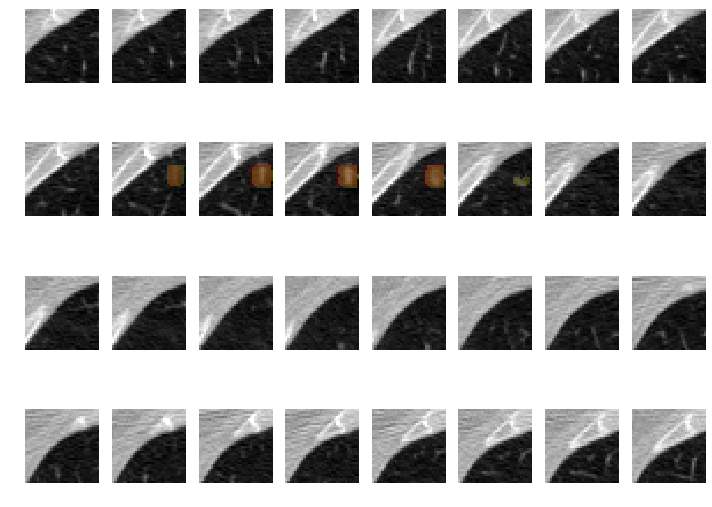

In [81]:
batch = train_iter.next()


data[:] = batch.data[0]       
label[:] = batch.label[0]
# predict
outputs = exe.forward(is_train=False)


p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X*x_std+x_mean
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], 'gray',vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.5, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.plasma, alpha=0.2, vmin=0, vmax=1)

      
plt.tight_layout()

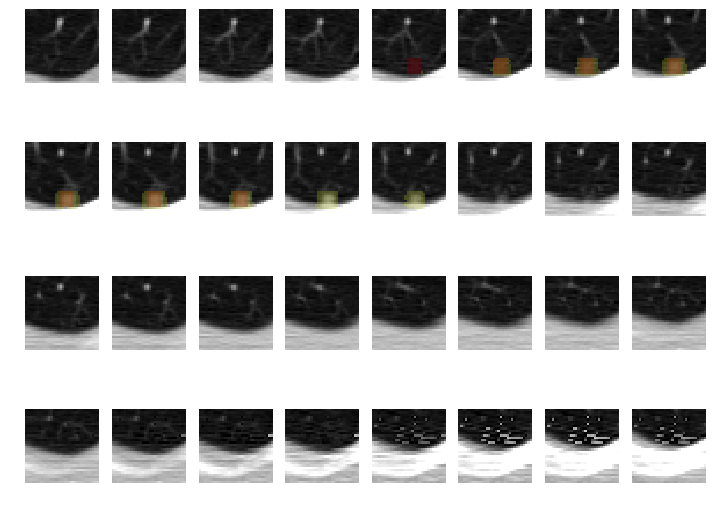

In [82]:
batch = train_iter.next()


data[:] = batch.data[0]       
label[:] = batch.label[0]
# predict
outputs = exe.forward(is_train=False)


p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X*x_std+x_mean
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], 'gray',vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.5, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.plasma, alpha=0.2, vmin=0, vmax=1)

      
plt.tight_layout()

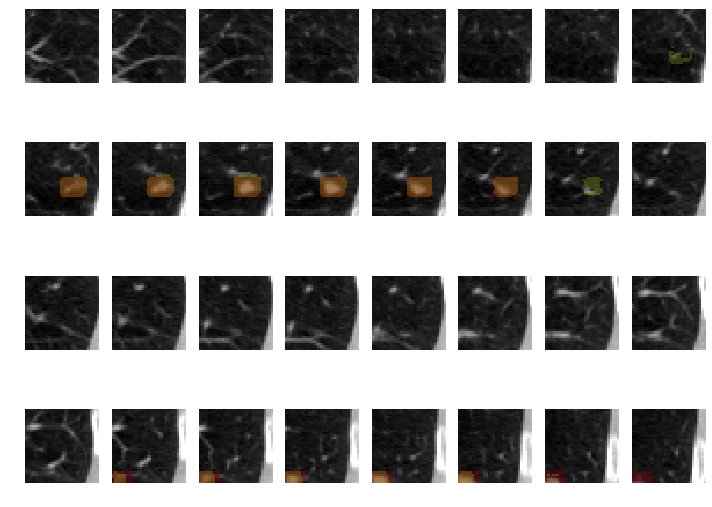

In [84]:
batch = train_iter.next()


data[:] = batch.data[0]       
label[:] = batch.label[0]
# predict
outputs = exe.forward(is_train=False)


p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X*x_std+x_mean
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], 'gray',vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.5, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.plasma, alpha=0.2, vmin=0, vmax=1)

      
plt.tight_layout()

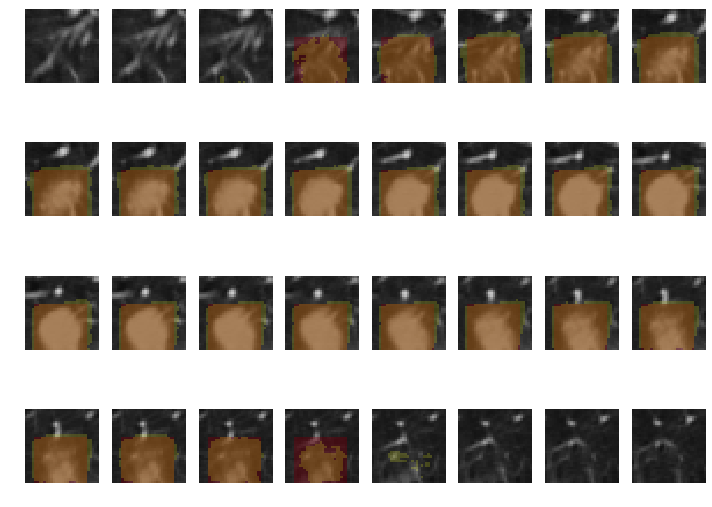

In [85]:
batch = train_iter.next()


data[:] = batch.data[0]       
label[:] = batch.label[0]
# predict
outputs = exe.forward(is_train=False)


p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X*x_std+x_mean
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], 'gray',vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.5, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.plasma, alpha=0.2, vmin=0, vmax=1)

      
plt.tight_layout()

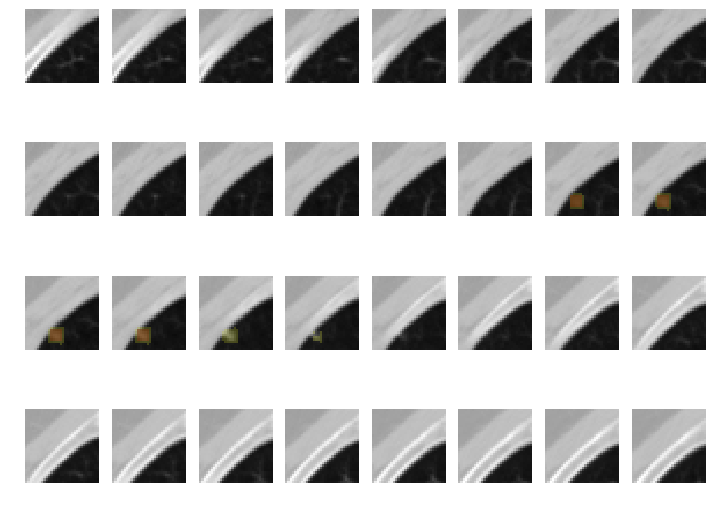

In [86]:
batch = train_iter.next()


data[:] = batch.data[0]       
label[:] = batch.label[0]
# predict
outputs = exe.forward(is_train=False)


p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X*x_std+x_mean
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], 'gray',vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.5, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.plasma, alpha=0.2, vmin=0, vmax=1)

      
plt.tight_layout()

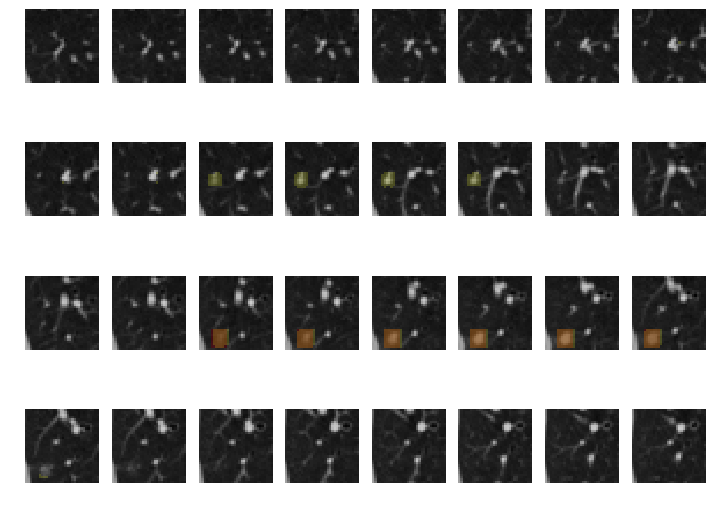

In [87]:
batch = train_iter.next()


data[:] = batch.data[0]       
label[:] = batch.label[0]
# predict
outputs = exe.forward(is_train=False)


p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X*x_std+x_mean
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], 'gray',vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.5, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.plasma, alpha=0.2, vmin=0, vmax=1)

      
plt.tight_layout()

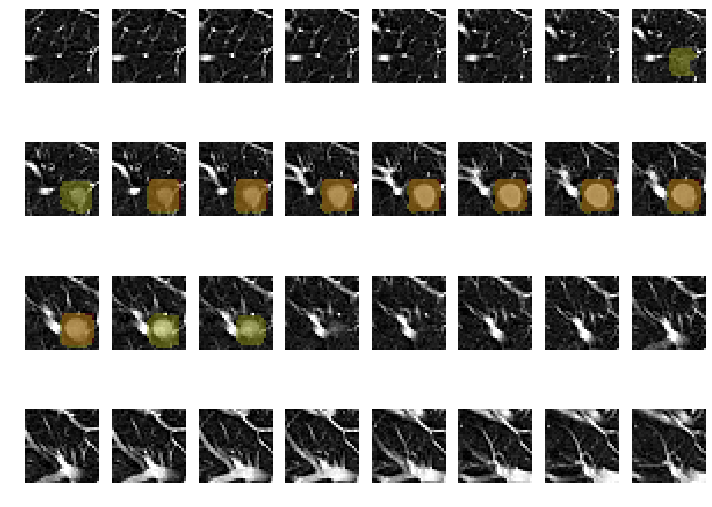

In [90]:
batch = train_iter.next()


data[:] = batch.data[0]       
label[:] = batch.label[0]
# predict
outputs = exe.forward(is_train=False)


p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X*x_std+x_mean
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], 'gray',vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.5, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.plasma, alpha=0.3, vmin=0, vmax=1)

      
plt.tight_layout()

In [0]:
import sys
sys.path.insert(0,"x110/DLToolboxImg/src/")
import pylidc as pl #pip install -Iv scikit-image==0.13
from random import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy
import random
import os
from imports import *

In [0]:
#!pip install pylidc
#!rm /root/.pylidcrc
#!echo $'[dicom]\npath = {root_path+"LIDC/DOI/"}\nwarn = True'>> /root/.pylidcrc
#!cat /root/.pylidcrc

In [0]:
#qu = pl.query(pl.Scan)
#scans=qu.all() #all scans in the original LIDC dataset
#scans[0:5]

In [2]:
scan_id =16
scan_1 = ctscan(scan_id)

Loading dicom files ... This may take a moment.


In [3]:
#resize volume


Vol0=scan_1.image_normalized #zxy
Kn,In,Jn=Vol0.shape

In = In//32*32
Jn = Jn//32*32
Kn = Kn//32*32

print(Kn,In,Jn)

Vol0=Vol0[:Kn,:In,:Jn].copy()
print(Vol0.shape)

Scann=Vol0.copy()


320 320 320
(320, 320, 320)


In [4]:
scan_1.image_normalized.shape,scan_1.image_resampled.shape

((332, 340, 340), (332, 340, 340))

In [0]:
#scan_1.image_resampled

In [7]:

Vol0=scan_1.image_resampled #zxy
Kn,In,Jn=Vol0.shape

In = In//32*32
Jn = Jn//32*32
Kn = Kn//32*32

print(Kn,In,Jn)

Vol0=Vol0[:Kn,:In,:Jn].copy()
print(Vol0.shape)

Scann2=Vol0.copy()

320 320 320
(320, 320, 320)


In [8]:

Vol0=scan_1.image_normalized #zxy
Kn,In,Jn=Vol0.shape

In = In//32*32
Jn = Jn//32*32
Kn = Kn//32*32

print(Kn,In,Jn)

Vol0=Vol0[:Kn,:In,:Jn].copy()
print(Vol0.shape)

Scann=Vol0.copy()

320 320 320
(320, 320, 320)


In [9]:
#decompose into minicubes

Vol1=[]

for k in range(0,Kn,32):
    for i in range(0,In,32):
        for j in range(0,Jn,32):
            Vol1.append(Vol0[k:k+32,i:i+32,j:j+32])

#plt.imshow(Vol0[0,:,:])

len(Vol1),Vol1[-1].shape

(1000, (32, 32, 32))

In [0]:
X_train = Vol1.copy()

In [0]:
#Split Y into minicubes
Vol0=scan_1.Z2 #zxy
Vol0=Vol0[:Kn,:In,:Jn].copy()
Yn=Vol0.copy()
Vol1=[]

for k in range(0,Kn,32):
    for i in range(0,In,32):
        for j in range(0,Jn,32):
            Vol1.append(Vol0[k:k+32,i:i+32,j:j+32])

#plt.imshow(Vol0[0,:,:])

In [0]:
Y_train = Vol1.copy()

In [0]:
#Prepare Data into the format expected by the model

In [15]:
X_train2 = [ np.expand_dims(e, axis=0) for e in X_train]

X_train3 = np.array(X_train2)

mean_image =.28
std_image = .28

X_train4= X_train3 - mean_image
X_train4 = X_train4/std_image
X_train4.shape

(1000, 1, 32, 32, 32)

In [16]:
Y_train2 = [j.reshape((32*32*32)) for j in Y_train]

#Y_train2 = [ np.expand_dims(e, axis=0) for e in Y_train2]
#Y_train2[-1].shape

Y_train3 = np.array(Y_train2)

Y_train3.shape

(1000, 32768)

In [0]:
#Make a prediction on each cube

In [0]:
root_path = '/content/drive/My Drive/x110/'

In [0]:


model_path = root_path+"model/model16/feb02"
model_epoch=108


In [20]:
import mxnet as mx

bs=1 #note that the bs should be a divisor of the number of data in the iterator.
train_iter = mx.io.NDArrayIter(X_train4, Y_train3, batch_size=bs)
input_shapes = dict(train_iter.provide_data+train_iter.provide_label)
print ('input_shapes', input_shapes)



input_shapes {'data': (1, 1, 32, 32, 32), 'softmax_label': (1, 32768)}


In [0]:
network, arg_params, aux_params = mx.model.load_checkpoint(model_path , model_epoch)

# Binding
exe = network.simple_bind(ctx=mx.gpu(0), **input_shapes)
# get handle to input arrays
arg_arrays = dict(zip(network.list_arguments(), exe.arg_arrays))
data = arg_arrays[train_iter.provide_data[0][0]]
label = arg_arrays[train_iter.provide_label[0][0]]


exe.copy_params_from(arg_params, aux_params)

In [0]:
K = train_iter.num_data
ps=[]
train_iter.reset()
for batch in train_iter:

    data[:] = batch.data[0]       
    label[:] = batch.label[0]

    outputs = exe.forward(is_train=False)
    p = outputs[0].asnumpy()
    ps.append(p)
w = [xx.reshape(32,32,32) for x in ps for xx in list(x)]

In [0]:
Vol1=w.copy()
A=np.zeros((Kn,In,Jn))
m=0

for k in range(0,Kn,32):
    for i in range(0,In,32):
        for j in range(0,Jn,32):
            z,x,y=np.array(Vol1[m]).shape
            A[k:k+z,i:i+x,j:j+y]=Vol1[m]
            m=m+1

In [0]:
%matplotlib nbagg

In [30]:
image3d=Scann#scan_1.image_normalized
Y = Yn.copy()#scan_1.Z2
p = np.array(A)

Y= np.ma.masked_where(Y == 0, Y)
msk20 = p>.5#.001
#msk20
S,B=get_segmented_lungs2(Scann2, plot=False)
msk2 = msk20 & B

msk2=msk2*1
msk2= np.ma.masked_where(msk2 ==0, msk2)

fig = plt.figure(figsize=(5,5)) # make figure
ax = plt.subplot(1,1,1)
im = plt.imshow(image3d[0],'gray',vmin=0,vmax=1)
im2 = plt.imshow(Y[0],interpolation='none', cmap=plt.cm.Reds, alpha=.7, vmin=0, vmax=1)
im3 = plt.imshow(msk2[0],interpolation='none', cmap=plt.cm.plasma,alpha=.4, vmin=0, vmax=1)


ztot=5
rects=[patches.Rectangle((512,512),1,1,linewidth=1,edgecolor='r',facecolor='none') for i in range(ztot)]




for r in rects:
    ax.add_patch(r)



# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(image3d[j])
    im2.set_array(Y[j])
    im3.set_array(msk2[j])



    for i in range(ztot):
        if i <len(scan_1.Zbbox[j]):
            rects[i].set_xy(scan_1.Zbbox[j][i][0:2])
            rects[i].set_height(scan_1.Zbbox[j][i][2])
            rects[i].set_width(scan_1.Zbbox[j][i][3])
        else:
            rects[i].set_xy([512,512])


    ax.set_title("Slice"+str(j))
    return im,im2,im3,rects

# kick off the animation
ani = animation.FuncAnimation(fig, updatefig, frames=range(len(image3d)),
                              interval=50, blit=True)
ani.save(root_path+'Chest_Cavity90.gif', writer='imagemagick')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [0]:
ani.save(root_path+'Chest_Cavity90.gif', writer='imagemagick')


In [0]:
#! apt-get install -y axel imagemagick